<a href="https://colab.research.google.com/github/nightmarewarrior/homework/blob/main/homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pymystem3
!pip install pymorphy3
!pip install razdel
!pip install gensim
!pip install nltk
!pip install rusenttokenize
!pip install regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 66.3 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
import re
import numpy as np
import pandas as pd
import pymorphy3 as pm
import gensim
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')
from pymorphy3.analyzer import Parse, MorphAnalyzer
morph = MorphAnalyzer()
import re


import keras
print(keras.__version__)

3.8.0


Задание 1:

In [7]:
wiki = open('wiki_data.txt', encoding="utf-8").read().split('\n')

In [ ]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]

    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return lemmatized_tokens

In [ ]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

vocab_size = len(id2word)

sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [ ]:
# skip gram
def gen_batches_sg(sentences, window = 20, batch_size=1000):


    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
#skipgram
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=len(word2id), output_dim=3000)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(word2id), output_dim=3000)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_sg(sentences[:19000], window=20),
          validation_data=gen_batches_sg(sentences[1900:],  window=10),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
          epochs=10)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.7370 - loss: 0.5280 - val_accuracy: 0.7982 - val_loss: 0.4884
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.7937 - loss: 0.4862 - val_accuracy: 0.7743 - val_loss: 0.5352
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8067 - loss: 0.4505 - val_accuracy: 0.7899 - val_loss: 0.4861
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8074 - loss: 0.4485 - val_accuracy: 0.8019 - val_loss: 0.4630
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.8131 - loss: 0.4398 - val_accuracy: 0.7931 - val_loss: 0.5178
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.8305 - loss: 0.4108 - val_accuracy: 0.9420 - val_loss: 0.1568
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8074 - loss: 0.4589 - val_accuracy: 0.8896 - val_loss: 0.2852
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.8091 -

In [ ]:
embeddings = model.layers[2].get_weights()[0]
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


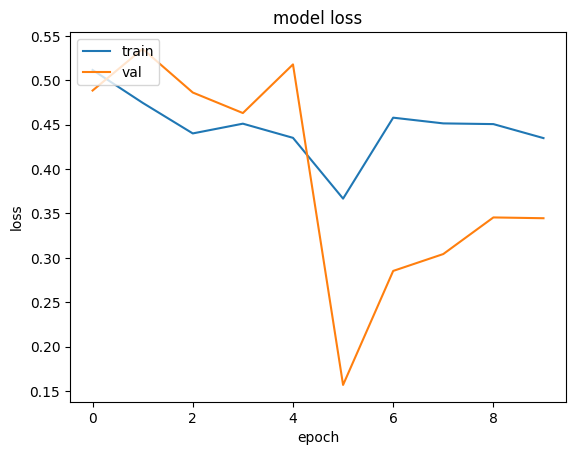

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
most_similar('луна', embeddings)

['луна',
 'телескоп',
 'созвездие',
 'комета',
 'спектральный',
 'орлеан',
 'юпитер',
 'сатурн',
 'кратер',
 'модуль']

In [ ]:
most_similar('кувшин', embeddings)

['кувшин',
 'лопатин',
 'кассия',
 'заказник',
 'гомер',
 'рекс',
 'эндемичный',
 'мусор',
 '«истории»',
 'уфимский']

In [ ]:
#cbow

# # cbow
def gen_batches_cbow(sentences, window = 20 , batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
model.fit(gen_batches_sg(sentences[:19000], window=20),
          validation_data=gen_batches_sg(sentences[1900:],  window=20),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
          epochs=10)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.8500 - loss: 0.3652 - val_accuracy: 0.8767 - val_loss: 0.3228
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8494 - loss: 0.3671 - val_accuracy: 0.8435 - val_loss: 0.3964
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.8499 - loss: 0.3662 - val_accuracy: 0.8282 - val_loss: 0.4514
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8516 - loss: 0.3653 - val_accuracy: 0.8557 - val_loss: 0.3804
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8549 - loss: 0.3590 - val_accuracy: 0.8399 - val_loss: 0.4098
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8662 - loss: 0.3396 - val_accuracy: 0.8903 - val_loss: 0.2878
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.8554 - loss: 0.3625 - val_accuracy: 0.8811 - val_loss: 0.3005
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.8531 -

In [ ]:
embeddings = model.layers[2].get_weights()[0]
most_similar('кружка', embeddings)

['кружка',
 'кружок',
 'мусор',
 'гомер',
 'фольклорный',
 'учительский',
 'заказник',
 'афанасьев',
 'пропагандистский',
 'окружность']

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


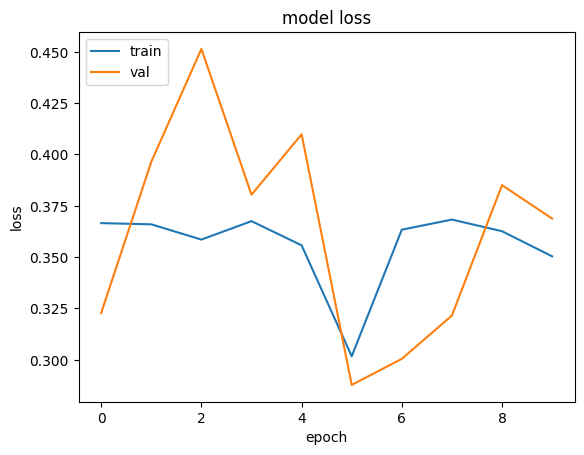

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
most_similar('лапа', embeddings)

['лапа',
 'коготь',
 'крокодил',
 'эндемичный',
 'микроэлемент',
 'бурый',
 'тупой',
 'лопасть',
 'сквозной',
 'морда']

В целом вышло не так уж и плохо, правда не понятно, почему модели так нравится слово "эндемичный" и "гомер". Не уверена, что проблема решится изменением параметров, что-то подсказывает, что проблема в исходном корпусе.
(Например, штангенциркуля в словаре не оказалось :) )

# Задание 2 (2 балла)

In [ ]:
wiki = open('wiki_data.txt', encoding='utf8').read().split('\n')
texts = [preprocess(text) for text in wiki]

In [ ]:
w2vec = gensim.models.Word2Vec(texts,
                             vector_size=800,
                             min_count=40,
                             max_vocab_size=100000,
                             window=20,
                             epochs=5,
                             hs=0,
                             negative=1,
                             sample=1e-4,
                             sg=0)

In [ ]:
w2vec.wv.most_similar('мост')

[('вокзал', 0.9443551301956177),
 ('железный', 0.915842592716217),
 ('дорога', 0.9004156589508057),
 ('поезд', 0.8990836143493652),
 ('пешеходный', 0.8949716091156006),
 ('маршрут', 0.8906700015068054),
 ('станция', 0.8779182434082031),
 ('тоннель', 0.8763530850410461),
 ('участок', 0.8730763792991638),
 ('пустить', 0.8662769198417664)]

In [ ]:
fsttxt = gensim.models.FastText(texts, min_n=5, max_n=15)


In [ ]:
fsttxt.wv.most_similar('штурвал')

[('штурмовка', 0.8894128799438477),
 ('штурмовик', 0.8871444463729858),
 ('артобстрел', 0.8636941909790039),
 ('штурм', 0.8586822748184204),
 ('батаан', 0.8461494445800781),
 ('фортов', 0.8388665318489075),
 ('«выстрел»', 0.8367952108383179),
 ('обстрел', 0.8331822156906128),
 ('штурмбаннфюрер', 0.8327513337135315),
 ('пулемётчик', 0.8284543752670288)]

In [ ]:
data = pd.read_csv('labeled.csv')
train, test = train_test_split(data, test_size=0.05, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)
def text_to_vector(vectorizer, new_text):
    tokens = preprocess(new_text)
    vector = np.zeros(vectorizer.vector_size)
    count = 0
    for token in tokens:
        if token in vectorizer.wv:
            vector += vectorizer.wv[token]
            count += 1
    if count > 0:
        vector /= count
    return vector
X = []
for comment in train['comment'].values:
    X.append(text_to_vector(w2v, comment))
y = train['toxic'].values
classifier = LogisticRegression(solver ="liblinear", penalty="l2")
classifier.fit(X, y)

# Задание 3 (3 балла)

In [ ]:
data = pd.read_csv('labeled.csv')

In [ ]:
!wget https://rusvectores.org/static/models/rusvectores4/taiga/taiga_upos_skipgram_300_2_2018.vec.gz

--2025-02-08 20:08:31--  https://rusvectores.org/static/models/rusvectores4/taiga/taiga_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 129.240.189.200, 2001:700:112::200
Connecting to rusvectores.org (rusvectores.org)|129.240.189.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346385366 (330M) [application/x-gzip]
Saving to: ‘taiga_upos_skipgram_300_2_2018.vec.gz’

taiga_upos_skipgram 100%[===================>] 330.34M  12.6MB/s    in 28s     

2025-02-08 20:08:59 (12.0 MB/s) - ‘taiga_upos_skipgram_300_2_2018.vec.gz’ saved [346385366/346385366]



In [36]:
import gensim
taiga_model = gensim.models.KeyedVectors.load_word2vec_format('taiga_upos_skipgram_300_2_2018.vec.gz', binary=False)

In [ ]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [ ]:
model.most_similar('солнце_NOUN')

[('солнца_NOUN', 0.7929109930992126),
 ('солнцо_NOUN', 0.790716290473938),
 ('солнышко_NOUN', 0.7722625136375427),
 ('солнцеаница_NOUN', 0.7690175771713257),
 ('солнец_NOUN', 0.7648512721061707),
 ('солнышк_NOUN', 0.7436351180076599),
 ('солнце_PROPN', 0.7301353216171265),
 ('солнышко_ADV', 0.7148886919021606),
 ('солнцеотреть_VERB', 0.7043485641479492),
 ('солнцааница_NOUN', 0.6912974119186401)]

In [ ]:
!wget https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map

--2025-02-08 20:09:52--  https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4093 (4.0K) [text/plain]
Saving to: ‘ru-rnc.map’

ru-rnc.map          100%[===================>]   4.00K  --.-KB/s    in 0s      

2025-02-08 20:09:52 (76.3 MB/s) - ‘ru-rnc.map’ saved [4093/4093]



In [ ]:
mapping = {}

for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [ ]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
data['norm_text'] = data.comment.apply(normalize_mystem)

In [ ]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд_NOUN, то_PART, за_ADP, что_PRON, деби..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол_NOUN, это_PART, отдушина_NOUN, затюканы..."
2,Собаке - собачья смерть\n,1.0,"[собака_NOUN, собачий_ADJ, смерть_NOUN]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница_NOUN, обновлять_VERB, дебил_NOUN, эт..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты_PRON, не_PART, убеждать_VERB, страничный_A..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий_ADJ, совковый_ADJ, скот_NOUN, прибега..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а_SCONJ, кто_PRON, любить_VERB, гоблин_NOUN, ..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть_VERB, утомленный_ADJ, солнце_NOUN,..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред_ADV, нарушать_VERB, правило_NOUN, р..."


In [45]:
def get_text_embedding(tokens, taiga_model):
    embeddings = []
    for token in tokens:
        if token in taiga_model:
            embeddings.append(taiga_model[token])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        # Если нет совпадений в модели, возвращаем нулевой вектор
        return np.zeros(taiga_model.vector_size, dtype='float32')

In [64]:
# Преобразуем все тексты в эмбеддинги
X = []
for tokens in data["norm_text"]:
    X.append(get_text_embedding(tokens, taiga_model))
X = np.array(X)  # итоговая матрица (num_samples x embedding_dim)

# Целевой вектор
y = data["toxic"].values

# 5) Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 6) Обучаем SGDClassifier
clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)

# 7) Предсказываем и считаем F1-медру
y_pred = clf.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1944
         1.0       0.87      0.78      0.82       939

    accuracy                           0.89      2883
   macro avg       0.88      0.86      0.87      2883
weighted avg       0.89      0.89      0.89      2883



# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [25]:
from keras.preprocessing.sequence import pad_sequences

In [1]:
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [2]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

In [3]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords

In [4]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))

In [5]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [14]:
tokenizer.build_vocab(wiki)

In [21]:
def gen_batches_neg_sampling(sentences, tokenizer, window=5,
                             batch_size=1000, maxlen=20,
                             negative_samples=5):
    """
    Генератор батчей с negative sampling без использования random.
    Пары (target, context) маркируем меткой 1.
    Для каждого положительного примера создаём negative_samples негативных (label=0),
    выбирая «фальшивый» контекст циклически из всего словаря.
    """
    vocab_list = list(tokenizer.vocab)
    half_window_left = (window // 2)  # целая часть
    half_window_right = window - half_window_left

    X, y = [], []

    # Индекс для циклического выбора слов
    negative_idx = 0

    while True:
        for sent in sentences:
            sent_enc = tokenizer(sent)
            length = len(sent_enc)
            if length < 2:
                continue

            for i in range(length):
                # Таргет
                target_subtokens = sent_enc[i]

                # Собираем реальный контекст
                left_context_idx = max(0, i - half_window_left)
                right_context_idx = min(length, i + half_window_right + 1)
                context_tokens = sent_enc[left_context_idx:i] + sent_enc[i+1:right_context_idx]

                # ПОЛОЖИТЕЛЬНЫЕ ПРИМЕРЫ
                for context_word in context_tokens:
                    X.append(target_subtokens)
                    y.append(1)

                    # НЕГАТИВНЫЕ ПРИМЕРЫ (label=0), без random:
                    for _ in range(negative_samples):
                        # Берём слово из словаря по циклу
                        fake_context_id = vocab_list[negative_idx % len(vocab_list)]
                        negative_idx += 1

                        # Здесь у нас input остаётся таргет,
                        # а "фейковый" контекст служит лишь для метки 0
                        X.append(target_subtokens)
                        y.append(0)

                # Накопили достаточно примеров -> делаем yield
                if len(X) >= batch_size:
                    X_padded = pad_sequences(X, maxlen=maxlen)
                    y_arr = np.array(y, dtype='int32')
                    yield (X_padded, y_arr)
                    X, y = [], []

        # Когда доходим до конца списка предложений, если что-то осталось, отдадим остаток
        if X:
            X_padded = pad_sequences(X, maxlen=maxlen)
            y_arr = np.array(y, dtype='int32')
            yield (X_padded, y_arr)
            X, y = [], []


In [22]:
model = keras.Sequential()
model.add(keras.layers.Embedding(
    input_dim=len(tokenizer.vocab),
    output_dim=100
))
model.add(keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)))

model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy'
)

In [23]:
model.build((None, 10))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 100)             │       5,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,486,101 (20.93 MB)

 Trainable params: 5,486,101 (20.93 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
train_sentences = wiki[:19000]
valid_sentences = wiki[19000:]

train_gen = gen_batches_neg_sampling(
    train_sentences,
    tokenizer,
    window=10,
    batch_size=100,
    maxlen=10,
    negative_samples=5
)

valid_gen = gen_batches_neg_sampling(
    valid_sentences,
    tokenizer,
    window=10,
    batch_size=100,
    maxlen=10,
    negative_samples=5
)

model.fit(
    train_gen,
    validation_data=valid_gen,
    steps_per_epoch=1000,
    validation_steps=100,
    epochs=5
)


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5967 - val_loss: 0.4815
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4705 - val_loss: 0.4585
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4603 - val_loss: 0.4584
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4566 - val_loss: 0.4554
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4545 - val_loss: 0.4541


dict_keys(['loss', 'val_loss'])


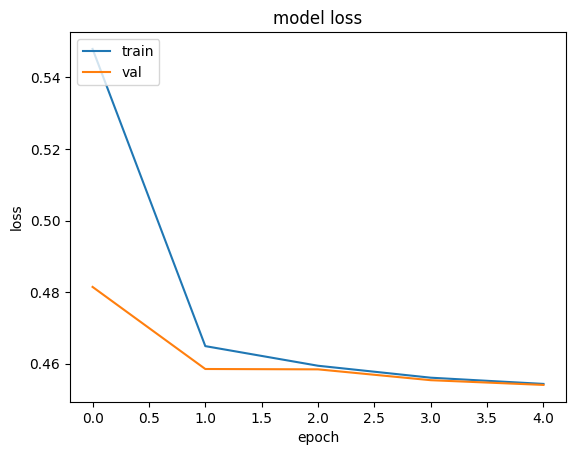

In [27]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
embeddings = model.layers[0].get_weights()[0] # матрица со всеми эмбедингами
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar


In [30]:
most_similar_ft('циркуль', embeddings, tokenizer)

['руль',
 '«локомотив-белогорье»',
 'ревель',
 'скульптора',
 'циркуляции',
 'руководитель',
 'портфель',
 'культовых',
 'пережить',
 'туберкулёзом',
 'корабль',
 'суперкубка',
 'беатифицирована',
 'исключительное',
 'законодательстве',
 'туннель',
 'культурные',
 'декоративно-прикладного',
 'пользователь',
 'основатель']

In [31]:
most_similar_ft('штанга', embeddings, tokenizer)

['вахтанга',
 'манга',
 'рейхстага',
 'ранга',
 'расчета',
 'дагестана',
 'восстанавливать',
 'теста',
 'коэффициента',
 'дагестанского',
 'останавливается',
 'бонапарта',
 'нога',
 'напечатана',
 'будапешта',
 'ста',
 'останавливались',
 'англоязычных',
 'ассистента',
 'восстанавливается']